In [3]:
import pandas as pd
import datetime
import numpy as np

#시각화
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
sns.set_style('whitegrid')
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)


#모델링
from sklearn.metrics import silhouette_score , silhouette_samples
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from bayes_opt import BayesianOptimization

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import StratifiedKFold , KFold

from imblearn.over_sampling import SMOTE , ADASYN

|Column 명|설명|상세|
|---|---|---|
SEQ|서비스 요청 ID|무작위로 부여|
접수일|서비스 접수 일자|YYYY-MM-DD|
접수시각|서비스접수시각|HH:MM:SS|
장기서비스여부|0 : 단기, 1 : 장기||
최초서비스일|전체회차의 첫 서비스 일자|YYYY-MM-DD|
전체회차|||
현재회차|||
서비스일자|현재 요청의 서비스 일자|YYYY-MM-DD|
서비스시작시간|현재 서비스 시작 요청 시간|HH:MM:SS|
 서비스종료시간|현재 서비스 종료 요청 시간|HH:MM:SS|
 기존고객여부|0 : 신규, 1 : 기존||
 결재형태||미수 : 결재수단 확정 X|
 서비스주소|서비스요청주소|시/구|
 주거형태|||
 평수|||
 고객가입일|고객최초가입일|YYYY-MM-DD|
반려동물|반려동물 여부 및 분류||
부재중여부|0 : 재실, 1 : 부재||
우선청소|우선청소 요청 사항||
쿠폰사용여부|0 : 쿠폰미사용 1 : 쿠폰사용||
매니저생년월일||YYYY-MM-DD
매니저최초가입일||YYYY-MM-DD
매니저최초서비스일||YYYY-MM-DD
매니저성별|0:여성, 1:남성|
매니저사용휴대폰|매니저 사용 휴대폰 분류
매니저주소|매니저 자택 주소 | 시/군단위
매니저이동방법|
근무가능지역|매니저근무가능지역
CS교육이수여부|0 : 미이수, 1 : 이수
청소교육이수여부|0 : 미이수, 1 : 이수
부재중서비스가능여부|0 : 불가능, 1 : 가능
추천인여부|0 : 미추천, 1 : 추천인 존재
매칭성공여부|0 : 실패, 1 : 성공


- read data

In [4]:
pd.set_option('max_column',100)
data = pd.read_csv('./data/trainset.csv')
test= pd.read_csv('./data/testset_final.csv')
sub = pd.read_csv('./data/sample_submission_final.csv')

In [5]:
set(data.columns) - set(test.columns)

{'매니저주소', '매니저최초가입일', '매니저최초서비스일', '매칭성공여부'}

- 결측치 제거

In [6]:
#결측 제거

data[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법','평수']] = data[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법','평수']].fillna('정보없음')
data[['부재중여부','CS교육이수여부','청소교육이수여부']] = data[['부재중여부','CS교육이수여부','청소교육이수여부']].fillna(3)

test['결재형태'] = test['결재형태'].fillna('신용카드')
test[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법','평수']] = test[['반려동물','우선청소','매니저사용휴대폰','매니저이동방법','평수']].fillna('정보없음')
test[['부재중여부','CS교육이수여부','청소교육이수여부']] = test[['부재중여부','CS교육이수여부','청소교육이수여부']].fillna(3)

In [7]:
data['매니저생년월일'] = data['매니저생년월일'].apply(lambda x: int(x.split('-')[0]))

- Featrue engineering

In [8]:
#일자 데이터 datetime으로 변경
data_time_cols = ['접수일','접수시각', '최초서비스일', '서비스일자', '서비스시작시간','서비스종료시간', '고객가입일', '매니저최초가입일', '매니저최초서비스일']
test_time_cols = ['접수일','접수시각', '최초서비스일', '서비스일자', '서비스시작시간','서비스종료시간', '고객가입일']

data[data_time_cols] = data[data_time_cols].apply(pd.to_datetime)
test[test_time_cols] = test[test_time_cols].apply(pd.to_datetime)

In [10]:
#서비스요일 변경
data['서비스요일'] = data['서비스일자'].apply(lambda x: x.weekday())

test['서비스요일'] = test['서비스일자'].apply(lambda x: x.weekday())

In [9]:
# 고객가입일_time

data['고객가입_year'] = data['고객가입일'].dt.year
data['고객가입_month'] = data['고객가입일'].dt.month
data['고객가입_day'] = data['고객가입일'].dt.day
data['고객가입_요일'] = data['고객가입일'].dt.weekday

test['고객가입_year'] = test['고객가입일'].dt.year
test['고객가입_month'] = test['고객가입일'].dt.month
test['고객가입_day'] = test['고객가입일'].dt.day
test['고객가입_요일'] = test['고객가입일'].dt.weekday

In [11]:
# 서비스 주소 == 근무가능주소 
add_lst = list(data['서비스주소'].unique())

add_seoul = [i for i in add_lst if '서울' in i]
add_ch = [i for i in add_lst if '충남' in i]
add_gw = [i for i in add_lst if '강원' in i]
add_pt = [i for i in add_lst if '평택' in i]
add_gj = [i for i in add_lst if '광주' in i]
add_city = [i for i in add_lst if ('서울' in i) or ('경기' in i)]
add_bs = [i for i in add_lst if '부산' in i]

def add_modify(address):
    if address in add_seoul: return '서울'
    elif address in add_ch: return '천안/아산'
    elif address in add_gw: return '원주/춘천'
    elif address in add_pt: return '평택'
    elif address in add_gj: return '광주'
    elif address in add_city: return '수도권'
    elif address in add_bs: return '부산'
    else: return '기타'

def matching_add(service, possible):
    if service == possible:
        return 1
    elif (service == '서울') and (possible == '수도권'):
        return 1
    else :
        return 0

data['서비스주소_2'] = data['서비스주소'].apply(add_modify)
data['지역_매칭'] = data.apply(lambda x: matching_add(x.서비스주소_2,x.근무가능지역),axis=1)
data.drop('서비스주소_2',axis = 1,inplace = True)

test['서비스주소_2'] = test['서비스주소'].apply(add_modify)
test['지역_매칭'] = test.apply(lambda x: matching_add(x.서비스주소_2,x.근무가능지역),axis=1)
test.drop('서비스주소_2',axis = 1,inplace = True)

In [12]:
#서비스 총 시간
data['서비스시작시간'] = data['서비스시작시간'].apply(lambda x: x.hour)
data['서비스종료시간'] = data['서비스종료시간'].apply(lambda x: x.hour)

data['총서비스시간'] = data['서비스종료시간'] - data['서비스시작시간']

test['서비스시작시간'] = test['서비스시작시간'].apply(lambda x: x.hour)
test['서비스종료시간'] = test['서비스종료시간'].apply(lambda x: x.hour)

test['총서비스시간'] = test['서비스종료시간'] - test['서비스시작시간']

In [13]:
#서비스 월
data['서비스월'] = data['서비스일자'].apply(lambda x: x.month)
data['서비스DAY'] = data['서비스일자'].apply(lambda x: x.day)

test['서비스월'] = test['서비스일자'].apply(lambda x: x.month)
test['서비스DAY'] = test['서비스일자'].apply(lambda x: x.day)

In [14]:
#서비스일자와 접수일자 차이
def 서비스_접수_차이(service_day, recep_day):
    time = service_day - recep_day
    return time.days

data['서비스-접수-차이'] = data.apply(lambda x: 서비스_접수_차이(x.서비스일자,x.접수일),axis=1)
test['서비스-접수-차이'] = test.apply(lambda x: 서비스_접수_차이(x.서비스일자,x.접수일),axis=1)

In [15]:
#매니저 연령대

def age(recep_day,birth):
    return recep_day.year - int(birth) + 1
       
data['매니저연령'] = data.apply(lambda x: age(x.접수일,x.매니저생년월일),axis=1)
data['매니저연령대'] = data['매니저연령'].apply(lambda x: int(str(x)[0]))
data['매니저연령_qcut'] = data['매니저연령'].apply(lambda x: 0 if x <= 50 else ( 1 if x <= 52 else ( 2 if x <= 56 else ( 3 if x <= 60 else 4))))

test['매니저연령'] = test.apply(lambda x: age(x.접수일,x.매니저생년월일),axis=1)
test['매니저연령대'] = test['매니저연령'].apply(lambda x: int(str(x)[0]))
test['매니저연령_qcut'] = test['매니저연령'].apply(lambda x: 0 if x <= 50 else ( 1 if x <= 52 else ( 2 if x <= 56 else ( 3 if x <= 60 else 4))))

In [16]:
#부재중 서비스가능여부와 부재중여부 일치
def 부재중(possible,whether):
    return '서비스가능여부' + str(possible) + '/부재중여부' + str(whether)

data['부재중_일치'] = data.apply(lambda x : 부재중(x.부재중서비스가능여부,x.부재중여부),axis = 1)

test['부재중_일치'] = test.apply(lambda x : 부재중(x.부재중서비스가능여부,x.부재중여부),axis = 1)

In [17]:
#반려동물여부
data['반려동물여부'] = data['반려동물'].apply(lambda x : 1  if x in ['기타', '고양이', '개'] else 0 )

test['반려동물여부'] = test['반려동물'].apply(lambda x : 1  if x in ['기타', '고양이', '개'] else 0 )

In [18]:
#서비스이용기간 : 서비스일자 - 최초서비스일
data['서비스이용기간'] = (data['서비스일자'] - data['최초서비스일']).astype(str).apply(lambda x : int(x[:-5]))

test['서비스이용기간'] = (test['서비스일자'] - test['최초서비스일']).astype(str).apply(lambda x : int(x[:-5]))

In [19]:
#회차별 일자
data['회차별일자'] = data.apply(lambda x : x['서비스이용기간']/x['현재회차'], axis = 1)

test['회차별일자'] = test.apply(lambda x : x['서비스이용기간']/x['현재회차'], axis = 1)

In [20]:
#가입_최초서비스 : 최초서비스일 - 고객가입일
service_to_day = (data['최초서비스일'] - data['고객가입일']).median()
na_index = test['고객가입일'].isna()
test.loc[na_index, '고객가입일'] = test[test['고객가입일'].isna()].apply(lambda x : x['최초서비스일'] - service_to_day, axis = 1)

data['가입_최초서비스'] = (data['최초서비스일'] - data['고객가입일']).dt.days
test['가입_최초서비스'] = (test['최초서비스일'] - test['고객가입일']).dt.days

In [21]:
#접수시간
data['접수시간'] = data['접수시각'].dt.hour.fillna(-1)

test['접수시간'] = test['접수시각'].dt.hour.fillna(-1)

In [22]:
#서비스진행비율
data['서비스진행비율'] = data['현재회차'] / data['전체회차']

test['서비스진행비율'] = test['현재회차'] / test['전체회차']

In [23]:
#서비스연도, 서비스 계절
data['서비스연도'] = data['서비스일자'].dt.year
data['서비스계절'] = data['서비스일자'].dt.month.apply(lambda x : '겨울' if x in [12,1,2] else ( '봄' if x in [3,4,5] else ( '여름' if x in [6,7,8] else '가을')) )

test['서비스연도'] = test['서비스일자'].dt.year
test['서비스계절'] = test['서비스일자'].dt.month.apply(lambda x : '겨울' if x in [12,1,2] else ( '봄' if x in [3,4,5] else ( '여름' if x in [6,7,8] else '가을')) )

In [24]:
# 가입 유지 기간
data['이용연도'] = 2021 - data['고객가입일'].dt.year + 1

test['이용연도'] = 2021 - test['고객가입일'].dt.year + 1

In [25]:
#지역
data['지역'] = data['서비스주소'].apply(lambda x : x.split(' ')[0])
test['지역'] = test['서비스주소'].apply(lambda x : x.split(' ')[0])

location_dict = { key : num for num, key in enumerate(data['지역'].unique())}

data['지역'] = data['지역'].map(location_dict)
test['지역'] = test['지역'].map(location_dict)

In [26]:
# house_type
data['house_type'] = (data['평수'].astype(str) + data['반려동물여부'].astype(str) +data['주거형태'] + data['서비스주소'])
test['house_type'] = (test['평수'].astype(str) + test['반려동물여부'].astype(str) +test['주거형태'] + test['서비스주소'])

house = list( set(test['house_type'].unique()) - set(data['house_type'].unique()))
house = house + list(set(data['house_type'].unique()) - set(test['house_type'].unique())) 

data['house_type'] = data['house_type'].apply(lambda x : "기타" if x in house else x )
test['house_type'] = test['house_type'].apply(lambda x : "기타" if x in house else x )

In [27]:
# 서비스시작시각
# 시간이 안적힌것도 있움
data['서비스시작시각'] = data['서비스시작시간'].apply(lambda x : x // 6).apply(lambda x : 1 if x == 0 else x)

test['서비스시작시각'] = test['서비스시작시간'].apply(lambda x : x // 6).apply(lambda x : 1 if x == 0 else x)

In [28]:
# 서비스진행비율_qcut
data['서비스진행비율_qcut'] = data['서비스진행비율'].apply(lambda x: 0.2 if x <= 0.2 else (0.4 if x<=0.4 else(0.6 if x<= 0.6 else(0.8 if x<= 0.8 else 1))))

test['서비스진행비율_qcut'] = test['서비스진행비율'].apply(lambda x: 0.2 if x <= 0.2 else (0.4 if x<=0.4 else(0.6 if x<= 0.6 else(0.8 if x<= 0.8 else 1))))

In [29]:
# 서비스_접수_차이_qcut
data['서비스_접수_차이_qcut'] = data['서비스-접수-차이'].apply(lambda x: 0 if x <= 4 else ( 1 if x <= 7 else ( 2 if x <= 14 else ( 3 if x <= 21 else 4))))

test['서비스_접수_차이_qcut'] = test['서비스-접수-차이'].apply(lambda x: 0 if x <= 4 else ( 1 if x <= 7 else ( 2 if x <= 14 else ( 3 if x <= 21 else 4))))

In [30]:
# 서비스이용기간_qcut
data['서비스이용기간_qcut'] = data['서비스이용기간'].apply(lambda x: 0 if x <= 7 else ( 1 if x <= 14 else 2 ))

test['서비스이용기간_qcut'] = test['서비스이용기간'].apply(lambda x: 0 if x <= 7 else ( 1 if x <= 14 else 2 ))

In [31]:
# 접수시간_qcut
data['접수시간_qcut'] = data['접수시간'].apply(lambda x: 0 if x <= 11 else ( 1 if x <= 14 else ( 2 if x <= 18 else 3 )))

test['접수시간_qcut'] = test['접수시간'].apply(lambda x: 0 if x <= 11 else ( 1 if x <= 14 else ( 2 if x <= 18 else 3 )))

In [32]:
# 가입_최초서비스_qcut
data['가입_최초서비스_qcut'] = data['가입_최초서비스'].apply(lambda x : 0 if x <= 0 else ( 1 if x <= 37 else ( 2 if x <= 96 else ( 3 if x <= 235 else 4))))

test['가입_최초서비스_qcut'] = test['가입_최초서비스'].apply(lambda x : 0 if x <= 0 else ( 1 if x <= 37 else ( 2 if x <= 96 else ( 3 if x <= 235 else 4))))

In [33]:
# 회차별일자_qcut
data['회차별일자_qcut'] = data['회차별일자'].apply(lambda x : 0 if x<= 2 else( 1 if x <= 6 else ( 2 if x <= 9 else ( 3 if x <= 27 else 4))))

test['회차별일자_qcut'] = test['회차별일자'].apply(lambda x : 0 if x<= 2 else( 1 if x <= 6 else ( 2 if x <= 9 else ( 3 if x <= 27 else 4))))

In [34]:
# 전체회차 이상치 12로 변경
data['전체회차'] = data['전체회차'].apply(lambda x : 12 if x > 10 else x )

test['전체회차'] = test['전체회차'].apply(lambda x : 12 if x > 10 else x )

In [35]:
#교육 여부
def education(x):
    if x == 1:
        return '이수'
    elif x == 0:
        return '미이수'
    else:
        return '정보없음'
    
data['CS교육'] = data['CS교육이수여부'].apply(education)
data['청소교육'] = data['청소교육이수여부'].apply(education)
data['교육여부'] = data['CS교육'] + '/' + data['청소교육']

data = data.drop(['CS교육','청소교육'],axis = 1)

test['CS교육'] = test['CS교육이수여부'].apply(education)
test['청소교육'] = test['청소교육이수여부'].apply(education)
test['교육여부'] = test['CS교육'] + '/' + test['청소교육']

test = test.drop(['CS교육','청소교육'],axis = 1)

In [36]:
#서비스일자와 접수일자 차이
def 가입_접수_차이(sign_day, recep_day):
    time = recep_day - sign_day
    return time.days



data['가입_접수_차이'] = data.apply(lambda x: 가입_접수_차이(x.고객가입일,x.접수일),axis=1)
data['접수주기'] = data.apply(lambda x: x.가입_접수_차이 / x.전체회차,axis= 1)

test['가입_접수_차이'] = test.apply(lambda x: 가입_접수_차이(x.고객가입일,x.접수일),axis=1)
test['접수주기'] = test.apply(lambda x: x.가입_접수_차이 / x.전체회차,axis= 1)

In [37]:
#매니저가입이후년차
data['매니저가입이후년차'] = data.apply(lambda x: x.접수일.year - x.매니저최초가입일.year,axis=1)
manager_year = pd.DataFrame(data.groupby('매니저연령대')['매니저가입이후년차'].mean()).reset_index()
data = data.drop(['매니저가입이후년차'],axis = 1)

data = pd.merge(data,manager_year,on='매니저연령대',how='left')
test = pd.merge(test,manager_year,on='매니저연령대',how='left')

In [38]:
#서비스분기
data['서비스분기'] = data['서비스월'].apply(lambda x : '1분기' if x in [1,2,3] else ( '2분기' if x in [4,5,6] else ( '3분기' if x in [7,8,9] else '4분기')) )

test['서비스분기'] = test['서비스월'].apply(lambda x : '1분기' if x in [1,2,3] else ( '2분기' if x in [4,5,6] else ( '3분기' if x in [7,8,9] else '4분기')) )

In [39]:
def 시간분류_시작(x):
    if 1<= x <= 6:
        return '새벽_시작'
    elif 7<= x <= 12:
        return '아침_시작'
    elif 13 <= x <= 18:
        return '점심_시작'
    else:
        return '밤_시작'
    
    
def 시간분류_종료(x):
    if 1<= x <= 6:
        return '새벽_종료'
    elif 7<= x <= 12:
        return '아침_종료'
    elif 13 <= x <= 18:
        return '점심_종료'
    else:
        return '밤_종료'
    
data['서비스시작_하루'] = data['서비스시작시간'].apply(시간분류_시작)
data['서비스종료_하루'] = data['서비스종료시간'].apply(시간분류_종료)

test['서비스시작_하루'] = test['서비스시작시간'].apply(시간분류_시작)
test['서비스종료_하루'] = test['서비스종료시간'].apply(시간분류_종료)

In [40]:
#time_type
data['time_type'] = (data['서비스계절']+data['서비스요일'].astype(str)+data['서비스시작_하루']+data['서비스종료_하루'])
test['time_type'] = (test['서비스계절']+test['서비스요일'].astype(str)+test['서비스시작_하루']+test['서비스종료_하루'])

time = list(set(data['time_type'].unique()) - set(test['time_type'].unique()))
time = time + list(set(test['time_type'].unique()) - set(data['time_type'].unique()))

data['time_type'] = data['time_type'].apply(lambda x : "기타" if x in time else x )
test['time_type'] = test['time_type'].apply(lambda x : "기타" if x in time else x )

In [41]:
data['manager_type'] = (data['매니저사용휴대폰'] + data['매니저이동방법'] + data['근무가능지역'] + data['CS교육이수여부'].astype(str) + data['청소교육이수여부'].astype(str)+data['추천인여부'].astype(str))
test['manager_type'] = (test['매니저사용휴대폰'] + test['매니저이동방법'] + test['근무가능지역'] + test['CS교육이수여부'].astype(str) + test['청소교육이수여부'].astype(str)+data['추천인여부'].astype(str))

manager = list(set(data['manager_type'].unique()) - set(test['manager_type'].unique()))
manager = manager + list(set(test['manager_type'].unique()) - set(data['manager_type'].unique()))

data['manager_type'] = data['manager_type'].apply(lambda x : "기타" if x in manager else x )
test['manager_type'] = test['manager_type'].apply(lambda x : "기타" if x in manager else x )

In [42]:
#customer_type
data['customer_type'] = data['장기서비스여부'].astype(str) + data['기존고객여부'].astype(str) + data['서비스주소'] + data['쿠폰사용여부'].astype(str) + data['우선청소'] + data['부재중여부'].astype(str)
test['customer_type'] = test['장기서비스여부'].astype(str) + test['기존고객여부'].astype(str) + test['서비스주소'] + test['쿠폰사용여부'].astype(str) + test['우선청소'] + test['부재중여부'].astype(str)

customer = list(set(data['customer_type'].unique()) - set(test['customer_type'].unique()))
customer = customer + list(set(test['customer_type'].unique()) - set(data['customer_type'].unique()))

data['customer_type'] = data['customer_type'].apply(lambda x : "기타" if x in customer else x )
test['customer_type'] = test['customer_type'].apply(lambda x : "기타" if x in customer else x )

In [43]:
#region_type
data['region_type'] = data['서비스주소'] + data['근무가능지역'] + data['매니저이동방법']
test['region_type'] = test['서비스주소'] + test['근무가능지역'] + test['매니저이동방법']

region = list(set(data['region_type'].unique()) - set(test['region_type'].unique()))
region = region + list(set(test['region_type'].unique()) - set(data['region_type'].unique()))

data['region_type'] = data['region_type'].apply(lambda x : "기타" if x in region else x )
test['region_type'] = test['region_type'].apply(lambda x : "기타" if x in region else x )

In [44]:
cluster_manager_col = ['매니저사용휴대폰','매니저이동방법','근무가능지역','CS교육이수여부','청소교육이수여부','부재중서비스가능여부','추천인여부','매니저연령_qcut']

df = data.loc[:,cluster_manager_col]

label_encoding = ['매니저사용휴대폰','매니저이동방법','근무가능지역']
#라벨인코딩 방식
for i in label_encoding:
    encoder = LabelEncoder()
    encoder.fit(df[i])
    df[i] = encoder.transform(df[i])

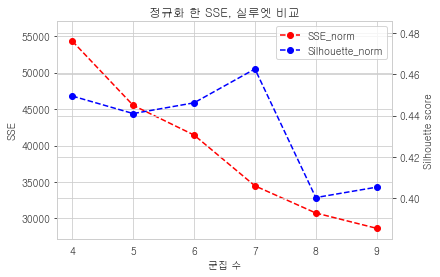

In [45]:
wssn = []
sisn = []
for k in range(4,10):
    kmeansn = KMeans(n_clusters=k,random_state= 1234)
    kmeansn.fit(df)
    wssn = np.append(wssn, kmeansn.inertia_)
    sisn = np.append(sisn, silhouette_score(df, kmeansn.labels_))

# 군집 수에 따른 SSE와 Silhouette score 시각화
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() #X축 공유해서 두 장이 합쳐진다.

line1 = ax1.plot(np.arange(4,10), wssn, 'ro--', label='SSE_norm')
line2 = ax2.plot(np.arange(4,10), sisn, 'bo--', label='Silhouette_norm') 

ax1.set_ylim(wssn.min()*0.95, wssn.max()*1.05)
ax2.set_ylim(sisn.min()*0.95, sisn.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.title('정규화 한 SSE, 실루엣 비교')
plt.legend(lines, labels)
plt.show()

In [46]:
sy2_km=KMeans(n_clusters=7 )
km = sy2_km.fit(df)

kmeans_manager = pd.DataFrame(km.labels_).rename(columns = {0:'kmeans_manager'})

data['kmeans_manager'] = kmeans_manager

cluster_manager_col_df = ['매니저사용휴대폰','매니저이동방법','근무가능지역','CS교육이수여부','청소교육이수여부','부재중서비스가능여부','추천인여부','매니저연령_qcut','kmeans_manager']
manager_df = data.loc[:,cluster_manager_col_df]
manager_df.drop_duplicates(inplace = True)

test = pd.merge(test,manager_df,on=cluster_manager_col,how='left')

mode = data['kmeans_manager'].value_counts().index[0]
test.fillna(mode,inplace=True)

In [47]:
cluster_customer_col = ['장기서비스여부','기존고객여부','결재형태','서비스주소','쿠폰사용여부','우선청소','부재중여부']

df = data.loc[:,cluster_customer_col]

label_encoding = ['결재형태','서비스주소','우선청소']
#라벨인코딩 방식
for i in label_encoding:
    encoder = LabelEncoder()
    encoder.fit(df[i])
    df[i] = encoder.transform(df[i])

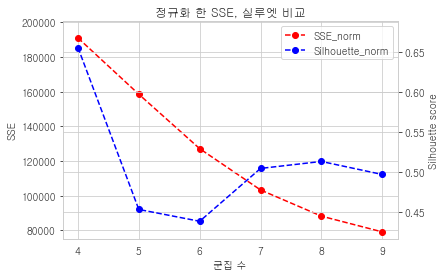

In [48]:
wssn = []
sisn = []
for k in range(4,10):
    kmeansn = KMeans(n_clusters=k,random_state= 1234)
    kmeansn.fit(df)
    wssn = np.append(wssn, kmeansn.inertia_)
    sisn = np.append(sisn, silhouette_score(df, kmeansn.labels_))

# 군집 수에 따른 SSE와 Silhouette score 시각화
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() #X축 공유해서 두 장이 합쳐진다.

line1 = ax1.plot(np.arange(4,10), wssn, 'ro--', label='SSE_norm')
line2 = ax2.plot(np.arange(4,10), sisn, 'bo--', label='Silhouette_norm') 

ax1.set_ylim(wssn.min()*0.95, wssn.max()*1.05)
ax2.set_ylim(sisn.min()*0.95, sisn.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]
plt.title('정규화 한 SSE, 실루엣 비교')
plt.legend(lines, labels)
plt.show()

In [49]:
sy2_km=KMeans(n_clusters=7 )
km = sy2_km.fit(df)

kmeans_customer = pd.DataFrame(km.labels_).rename(columns = {0:'kmeans_customer'})

data['kmeans_customer'] = kmeans_customer

cluster_customer_col_df = ['장기서비스여부','기존고객여부','결재형태','서비스주소','쿠폰사용여부','우선청소','부재중여부','kmeans_customer']
customer_df = data.loc[:,cluster_customer_col_df]
customer_df.drop_duplicates(inplace = True)

test = pd.merge(test,customer_df,on=cluster_customer_col,how='left')

mode = data['kmeans_customer'].value_counts().index[0]
test.fillna(mode,inplace=True)

- mean encoding

In [50]:
#mean_lst

mean_lst = ['장기서비스여부', '기존고객여부',
       '결재형태', '주거형태', '평수', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법',
       'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스요일',
        '서비스월', '매니저연령대', '부재중_일치',
       '반려동물여부', '접수시간', '서비스연도', '서비스계절','교육여부',
       '이용연도', '지역','서비스분기','house_type', '매니저연령_qcut', '서비스이용기간_qcut', '서비스진행비율_qcut', '회차별일자_qcut','manager_type','time_type','서비스시작_하루','서비스종료_하루','고객가입_year','고객가입_month',
            '고객가입_day','고객가입_요일','customer_type','kmeans_manager','kmeans_customer','region_type']

for i in mean_lst : 
    satisfaction = (data.groupby(i)['매칭성공여부'].mean() ).to_dict()
    name = i + '_만족도'
    data[name] = data[i].map(satisfaction)
    test[name] = test[i].map(satisfaction)
    
data = data.fillna(0)
test = test.fillna(0)

In [51]:
for i in mean_lst : 
    satisfaction = (data.query('매칭성공여부 == 1').groupby(i)['매칭성공여부'].agg('count') ).to_dict()
    name = i + '별count'
    data[name] = data[i].map(satisfaction)
    test[name] = test[i].map(satisfaction)
    
data = data.fillna(0)
test = test.fillna(0)

- encoding( label , one_hot_encoding )

In [52]:
label_encoding = ['결재형태','지역']

In [53]:
one_hot_encoding = ['장기서비스여부', '기존고객여부',
         '주거형태', '평수', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법',
        'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '서비스요일','지역_매칭',
        '서비스월', '매니저연령대', '부재중_일치',
        '반려동물여부', '서비스진행비율', '서비스연도', '서비스계절',
        '이용연도', '서비스시작시각', '교육여부','서비스분기','서비스DAY','house_type','manager_type','time_type'
                ,'서비스시작_하루','서비스종료_하루','customer_type','region_type']

In [54]:
#라벨인코딩 방식
for i in label_encoding:
    encoder = LabelEncoder()
    encoder.fit(data[i])
    data[i] = encoder.transform(data[i])
    test[i] = encoder.transform(test[i])

In [55]:
#원핫인코딩 방식
encoding_df = pd.DataFrame()
for i in one_hot_encoding:
    globals()['encoding_{}'.format(i)] = pd.get_dummies(data[i])
    encoding_df = pd.concat([encoding_df,globals()['encoding_{}'.format(i)]],axis=1)

data = data.drop(one_hot_encoding,axis=1)

encoding_test_df = pd.DataFrame()
for i in one_hot_encoding:
    if i == '서비스시작_하루':
        globals()['encoding_test_{}'.format(i)] = pd.get_dummies(test[i])
        globals()['encoding_test_{}'.format(i)]['밤_시작'] = 0
        globals()['encoding_test_{}'.format(i)] = globals()['encoding_test_{}'.format(i)][['밤_시작','새벽_시작','아침_시작','점심_시작']]
        encoding_test_df = pd.concat([encoding_test_df,globals()['encoding_test_{}'.format(i)]],axis=1)
    elif i == '서비스종료_하루':
        globals()['encoding_test_{}'.format(i)] = pd.get_dummies(test[i])
        globals()['encoding_test_{}'.format(i)]['새벽_종료'] = 0
        globals()['encoding_test_{}'.format(i)] = globals()['encoding_test_{}'.format(i)][['밤_종료','새벽_종료','아침_종료','점심_종료']]
        encoding_test_df = pd.concat([encoding_test_df,globals()['encoding_test_{}'.format(i)]],axis=1)
    else :
        globals()['encoding_test_{}'.format(i)] = pd.get_dummies(test[i])
        encoding_test_df = pd.concat([encoding_test_df,globals()['encoding_test_{}'.format(i)]],axis=1)
        
test = test.drop(one_hot_encoding,axis=1)

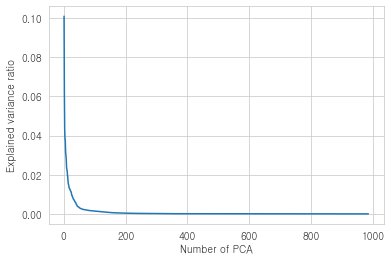

In [56]:
from sklearn.decomposition import PCA
pca=PCA().fit(encoding_df) 

plt.plot(np.arange(1,encoding_df.shape[1]+1), pca.explained_variance_ratio_)
plt.xlabel('Number of PCA')
plt.ylabel('Explained variance ratio')
plt.show()

In [57]:
pca = PCA(n_components=0.85) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(encoding_df)
pcatrain = pd.DataFrame(data=printcipalComponents)
# 주성분으로 이루어진 데이터 프레임 구성

printcipalComponents_test = pca.transform(encoding_test_df)
pcatest = pd.DataFrame(data=printcipalComponents_test)

In [58]:
encoding_df.iloc[:,:] = encoding_df.iloc[:,:].astype('int64')
data = pd.concat([data,pcatrain],axis=1)

encoding_test_df.iloc[:,:] = encoding_test_df.iloc[:,:].astype('int64')
test = pd.concat([test,pcatest],axis=1)

- 불필요한 column drop

In [59]:
data = data.drop(['접수시각','접수일','최초서비스일','서비스일자','서비스주소','고객가입일','매니저생년월일','매니저성별','근무가능지역','반려동물','매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis =1)

test = test.drop(['접수시각','접수일','최초서비스일','서비스일자','서비스주소','고객가입일','매니저생년월일','매니저성별','근무가능지역','반려동물'], axis =1)

- scaling

In [60]:
col1 = list(data.iloc[:,1:5].columns)
col2 = list(data.iloc[:,7:19].columns)
col3 = list(data.iloc[:,20:29].columns)
col4 = list(data.iloc[:,74:117].columns)

In [61]:
scale_lst = col1 + col2 + col3 + col4

In [62]:
scaler = StandardScaler()

data_scale = data[scale_lst]
test_scale = test[scale_lst]
data_scale = scaler.fit_transform(data_scale)
test_scale = scaler.transform(test_scale)

data[scale_lst] = data_scale
test[scale_lst] = test_scale

In [63]:
target = data['매칭성공여부']
data = data.drop(['매칭성공여부'],axis = 1)
data = data.iloc[:,1:]
test_id = test['SEQ']
test = test.iloc[:,1:]

- Feature Selection

(73, 0.9082961560645593)


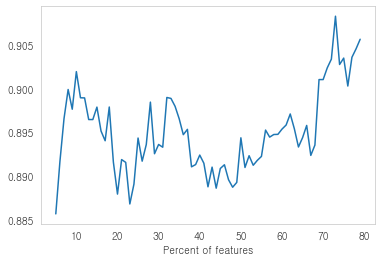

In [64]:
model = XGBClassifier(random_state= 0,use_label_encoder=False,eval_metric = 'logloss')

cv_scores = []
for p in range(5,80,1):
    X_new = SelectPercentile(percentile=p).fit_transform(data , target)    
    cv_score = cross_val_score(model, X_new, target, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid() 

In [65]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(data, target)
data = fs.transform(data)
test = fs.transform(test)

print(data.shape)

(23009, 143)


In [66]:
data = pd.DataFrame(data)
test = pd.DataFrame(test)

- ADASYN

In [1910]:
ada = ADASYN(sampling_strategy=0.2, random_state=1000)
X_res, y_res = ada.fit_resample(data, target)

- modeling

In [1913]:
test_id = pd.DataFrame(test_id)

In [1914]:
stk_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [1915]:
X_train, X_dev, y_train, y_dev = train_test_split(X_res, y_res ,stratify = y_res,  test_size=0.3,   random_state=0)

In [1916]:
ext = ExtraTreesClassifier(random_state = 0 )
ext.fit(X_train, y_train)

predict_ext_proba = ext.predict_proba(X_dev) #중요도 낮은거 제거 안함
predict_ext_proba = pd.DataFrame(predict_ext_proba)[[1]].rename(columns = {1:'pred'})
roc_auc_score(y_dev, predict_ext_proba)

0.968334801409353

In [1917]:
ext = ExtraTreesClassifier(random_state = 0 )
ext.fit(X_res, y_res)

predict_ext_proba = ext.predict_proba(test) #중요도 낮은거 제거 안함
predict_ext_proba = pd.DataFrame(predict_ext_proba)[[1]].rename(columns = {1:'pred'})
predict_ext_proba = pd.concat([test_id,predict_ext_proba],axis =1)

print(predict_ext_proba.pred.mean())

0.11647973609802074


In [1918]:
predict_ext_proba.to_csv('./submission/submission_2.csv',index= False)